In [ ]:

import os, sys, time, math, random
import numpy as np
import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [4]:

# 预检：检查数据目录结构是否存在，不存在则仅提示而不报错中断
import os
DATA_ROOT = "./"  # 如需修改，请在上方“导入与全局参数”单元修改并重新运行
expected = [
    os.path.join(DATA_ROOT, "USA_segmentation", "RGB_images"),
    os.path.join(DATA_ROOT, "USA_segmentation", "NRG_images"),
    os.path.join(DATA_ROOT, "USA_segmentation", "masks"),
]
ok = True
for p in expected:
    if not os.path.isdir(p):
        print("[WARN] 目录不存在：", p)
        ok = False
if ok:
    print("[OK] 数据目录结构完整。")
else:
    print("[HINT] 请将数据放置到上述目录，再继续运行后续单元。")

[OK] 数据目录结构完整。


## 1) 数据集划分：先分再算 / Train-Val-Test Split

In [6]:
from pathlib import Path
import re, collections

def list_states(dir_):
    pat = re.compile(r'(?:mask|RGB|NRG)_(?P<state>[a-z]{2}\d{3})_', re.I)
    bag = collections.Counter()
    for p in Path(dir_).rglob("*"):
        if p.is_file() and p.suffix.lower() in {".png",".jpg",".jpeg",".tif",".tiff"}:
            m = pat.search(p.name)
            if m: bag[m.group("state")] += 1
    return bag

ROOT = "./USA_segmentation"
print("RGB  :", list_states(f"{ROOT}/RGB_images"))
print("NRG  :", list_states(f"{ROOT}/NRG_images"))
print("MASKs:", list_states(f"{ROOT}/masks"))


RGB  : Counter({'mo097': 40, 'mo119': 33, 'mo199': 28, 'mo169': 27, 'ar039': 24, 'mo167': 24, 'mo103': 23, 'mo025': 21, 'ar145': 19, 'mo049': 17, 'mo075': 15, 'tx071': 14, 'tx159': 12, 'ar041': 11, 'wa065': 10, 'ar081': 9, 'nm039': 7, 'nm043': 7, 'wa041': 7, 'wa051': 6, 'ar037': 5, 'wa031': 5, 'wa057': 5, 'wa059': 5, 'tx097': 4, 'wa007': 4, 'wa009': 4, 'wa019': 4, 'wa027': 4, 'wa073': 4, 'nm006': 3, 'tx087': 3, 'wa053': 3, 'nm007': 2, 'or029': 2, 'or047': 2, 'wa011': 2, 'wa015': 2, 'wa047': 2, 'wa049': 2, 'wa063': 2, 'nm003': 1, 'nm019': 1, 'nm023': 1, 'nm028': 1, 'nm051': 1, 'or005': 1, 'or013': 1, 'or019': 1, 'or023': 1, 'or033': 1, 'or039': 1, 'or043': 1, 'wa003': 1, 'wa013': 1, 'wa023': 1, 'wa035': 1, 'wa037': 1, 'wa039': 1, 'wa061': 1, 'wa067': 1, 'wa077': 1})
NRG  : Counter({'mo097': 40, 'mo119': 33, 'mo199': 28, 'mo169': 27, 'ar039': 24, 'mo167': 24, 'mo103': 23, 'mo025': 21, 'ar145': 19, 'mo049': 17, 'mo075': 15, 'tx071': 14, 'tx159': 12, 'ar041': 11, 'wa065': 10, 'ar081': 9, '

In [7]:
import re, random
from pathlib import Path

ROOT = Path("./USA_segmentation")
RGB_DIR, NRG_DIR, MSK_DIR = ROOT/"RGB_images", ROOT/"NRG_images", ROOT/"masks"
SPLIT_DIR = ROOT/"splits"; SPLIT_DIR.mkdir(parents=True, exist_ok=True)
EXTS = {".png",".jpg",".jpeg",".tif",".tiff"}

# key = (state, year, mm, dd, idx)  例如 ('wa041','2019','10','33','0')
PAT = re.compile(r'^(?:mask|RGB|NRG)_(?P<state>[a-z]{2}\d{3})_(?P<yr>\d{4})_n_(?P<mm>\d{2})_(?P<dd>\d{2})_(?P<idx>\d+)\.', re.I)

def collect(dir_):
    d={}
    for p in Path(dir_).rglob("*"):
        if p.suffix.lower() in EXTS:
            m = PAT.match(p.name)
            if m:
                k = (m['state'].lower(), m['yr'], m['mm'], m['dd'], m['idx'])
                d.setdefault(k, []).append(p)
    return d

rgb = collect(RGB_DIR)
nrg = collect(NRG_DIR)
msk = collect(MSK_DIR)

common = sorted(set(rgb)&set(nrg)&set(msk))
print(f"[INFO] 共同样本数: {len(common)}")
if not common:
    print("[HINT] 没有共同键。请确认 RGB/NRG 与 MASK 是否来自同一州/同一批次。")
else:
    import cv2
    pos, neg = [], []
    for k in common:
        # 取其中一个 mask 路径读取判断是否有前景
        mpath = msk[k][0]
        m = cv2.imread(str(mpath), 0)
        ((pos if (m>0).any() else neg)).append("_".join(k))

    random.seed(2025)
    random.shuffle(pos); random.shuffle(neg)
    def split(arr, a=0.7, b=0.15):
        n=len(arr); na=int(n*a); nb=int(n*b); return arr[:na], arr[na:na+nb], arr[na+nb:]
    trp, vap, tep = split(pos); trn, van, ten = split(neg)
    train, val, test = trp+trn, vap+van, tep+ten
    for fn, lst in [("train.txt",train),("val.txt",val),("test.txt",test)]:
        (SPLIT_DIR/fn).write_text("\n".join(sorted(lst)), encoding="utf-8")
    print("Done:", {"train":len(train), "val":len(val), "test":len(test)})


[INFO] 共同样本数: 444
Done: {'train': 310, 'val': 65, 'test': 69}


In [25]:
# === offline_augment_sdt.py ===
# 将 train/val/test 中列出的 key 转为真实文件名：RGB_/NRG_/mask_
# 对每个样本做 HFlip / VFlip / Rot90 / Rot180 / Rot270，并保存到新目录。
import os, cv2, numpy as np
from pathlib import Path
from tqdm import tqdm
import random

# ---------- 配置 ----------
SRC_ROOT = Path("./USA_segmentation")     # 原数据根目录
DST_ROOT = Path("./USA_segmentation_aug") # 增强后输出根目录（不会覆盖原图）
IMAGE_EXT = ".png"                        # 如果是 .jpg/.tif 请改
MASK_EXT  = ".png"
SPLITS = ["train.txt"]                    # 只增强训练集；想全量就改成 ["train.txt","val.txt","test.txt"]
SEED = 2025
# --------------------------

random.seed(SEED)
SRC_RGB = SRC_ROOT / "RGB_images"
SRC_NIR = SRC_ROOT / "NRG_images"
SRC_MSK = SRC_ROOT / "masks"
SPLIT_DIR = SRC_ROOT / "splits"

# 输出目录
(DST_ROOT / "RGB_images").mkdir(parents=True, exist_ok=True)
(DST_ROOT / "NRG_images").mkdir(parents=True, exist_ok=True)
(DST_ROOT / "masks").mkdir(parents=True, exist_ok=True)

def key_to_names(key: str):
    # key: wa041_2019_10_33_0  ->  RGB_wa041_2019_n_10_33_0.png 等
    state, yr, mm, dd, idx = key.split("_")
    mid = f"{state}_{yr}_n_{mm}_{dd}_{idx}"
    return f"RGB_{mid}", f"NRG_{mid}", f"mask_{mid}"

# 几何变换：保证 RGB/NRG/mask 完全一致
def do_aug_triplet(rgb, nir, msk, aug_name):
    if aug_name == "hflip":
        return cv2.flip(rgb, 1), cv2.flip(nir, 1), cv2.flip(msk, 1)
    if aug_name == "vflip":
        return cv2.flip(rgb, 0), cv2.flip(nir, 0), cv2.flip(msk, 0)
    if aug_name == "r90":
        return (cv2.rotate(rgb, cv2.ROTATE_90_CLOCKWISE),
                cv2.rotate(nir, cv2.ROTATE_90_CLOCKWISE),
                cv2.rotate(msk, cv2.ROTATE_90_CLOCKWISE))
    if aug_name == "r180":
        return (cv2.rotate(rgb, cv2.ROTATE_180),
                cv2.rotate(nir, cv2.ROTATE_180),
                cv2.rotate(msk, cv2.ROTATE_180))
    if aug_name == "r270":
        return (cv2.rotate(rgb, cv2.ROTATE_90_COUNTERCLOCKWISE),
                cv2.rotate(nir, cv2.ROTATE_90_COUNTERCLOCKWISE),
                cv2.rotate(msk, cv2.ROTATE_90_COUNTERCLOCKWISE))
    raise ValueError(aug_name)

AUGS = ["hflip", "vflip", "r90", "r180", "r270"]  # 你也可以删减

def save_triplet(dst_root, key, aug, rgb, nir, msk):
    rgb_name, nir_name, msk_name = key_to_names(key)
    # 在原文件名后加 _aug-xxx
    cv2.imwrite(str(dst_root/"RGB_images"/f"{rgb_name}_aug-{aug}{IMAGE_EXT}"), cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR))
    cv2.imwrite(str(dst_root/"NRG_images"/f"{nir_name}_aug-{aug}{IMAGE_EXT}"), nir)
    cv2.imwrite(str(dst_root/"masks"/f"{msk_name}_aug-{aug}{MASK_EXT}"), (msk>0).astype(np.uint8)*255)

# 统计
total_keys = 0
for split_file in SPLITS:
    split_path = SPLIT_DIR / split_file
    if not split_path.exists():
        print(f"[WARN] 缺少 {split_path}，跳过。")
        continue
    keys = [x.strip() for x in split_path.read_text(encoding="utf-8").splitlines() if x.strip()]
    total_keys += len(keys)

print(f"[INFO] 预计处理样本数（不含增强倍数）：{total_keys}")
done = 0; saved = 0; bad = 0

for split_file in SPLITS:
    split_path = SPLIT_DIR / split_file
    if not split_path.exists(): 
        continue
    keys = [x.strip() for x in split_path.read_text(encoding="utf-8").splitlines() if x.strip()]
    for key in tqdm(keys, desc=f"Aug {split_file}", ncols=100):
        rgb_name, nir_name, msk_name = key_to_names(key)
        rgb_path = SRC_RGB / f"{rgb_name}{IMAGE_EXT}"
        nir_path = SRC_NIR / f"{nir_name}{IMAGE_EXT}"
        msk_path = SRC_MSK / f"{msk_name}{MASK_EXT}"
        # 读取
        rgb = cv2.imread(str(rgb_path), cv2.IMREAD_COLOR)
        nir = cv2.imread(str(nir_path), cv2.IMREAD_UNCHANGED)
        msk = cv2.imread(str(msk_path), cv2.IMREAD_GRAYSCALE)
        if rgb is None or nir is None or msk is None:
            bad += 1
            print(f"[ERR] 读取失败: {key}")
            continue
        rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
        msk = (msk > 127).astype(np.uint8)*255  # 二值化防止连带噪声

        # 逐个增强并保存
        for aug in AUGS:
            r2, n2, m2 = do_aug_triplet(rgb, nir, msk, aug)
            save_triplet(DST_ROOT, key, aug, r2, n2, m2)
            saved += 1
        done += 1

print(f"[DONE] 原样本处理: {done}, 失败: {bad}, 写出增强文件: {saved}（每个样本 {len(AUGS)} 份）")
print(f"[OUT ] 增强图像输出到: {DST_ROOT}")


[INFO] 预计处理样本数（不含增强倍数）：310


Aug train.txt: 100%|██████████████████████████████████████████████| 310/310 [00:51<00:00,  5.97it/s]

[DONE] 原样本处理: 310, 失败: 0, 写出增强文件: 1550（每个样本 5 份）
[OUT ] 增强图像输出到: USA_segmentation_aug


[SAVE] USA_segmentation_vis\wa059_2019_08_07_0_aug_grid.png


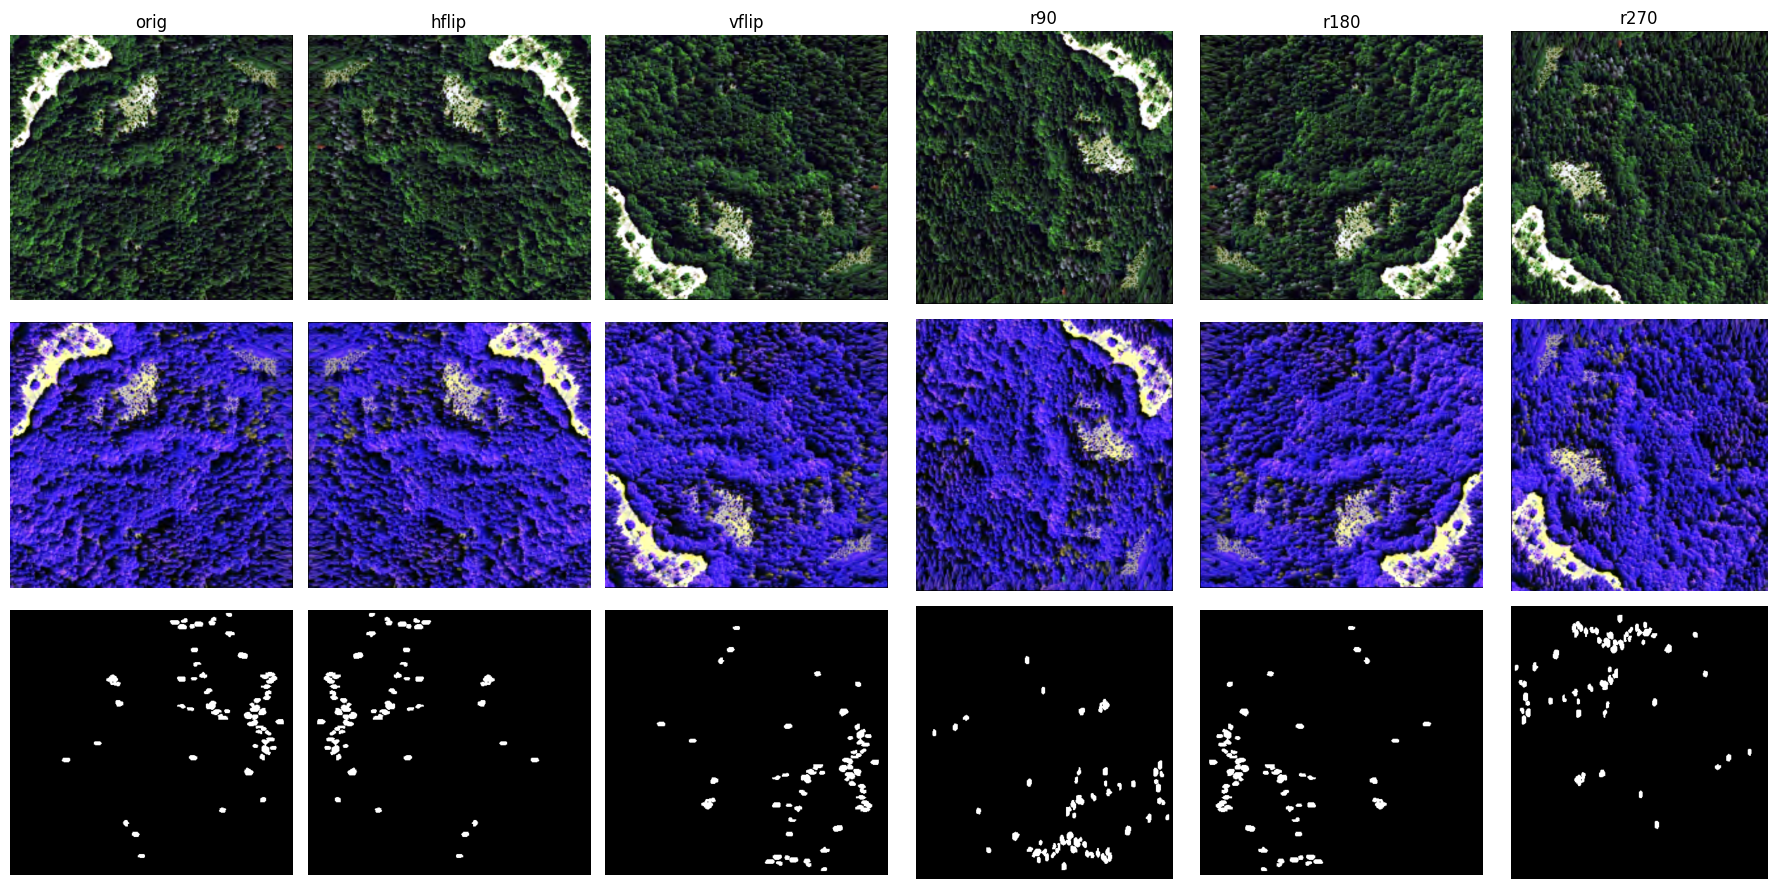

[SAVE] USA_segmentation_vis\mo103_2020_05_08_0_aug_grid.png


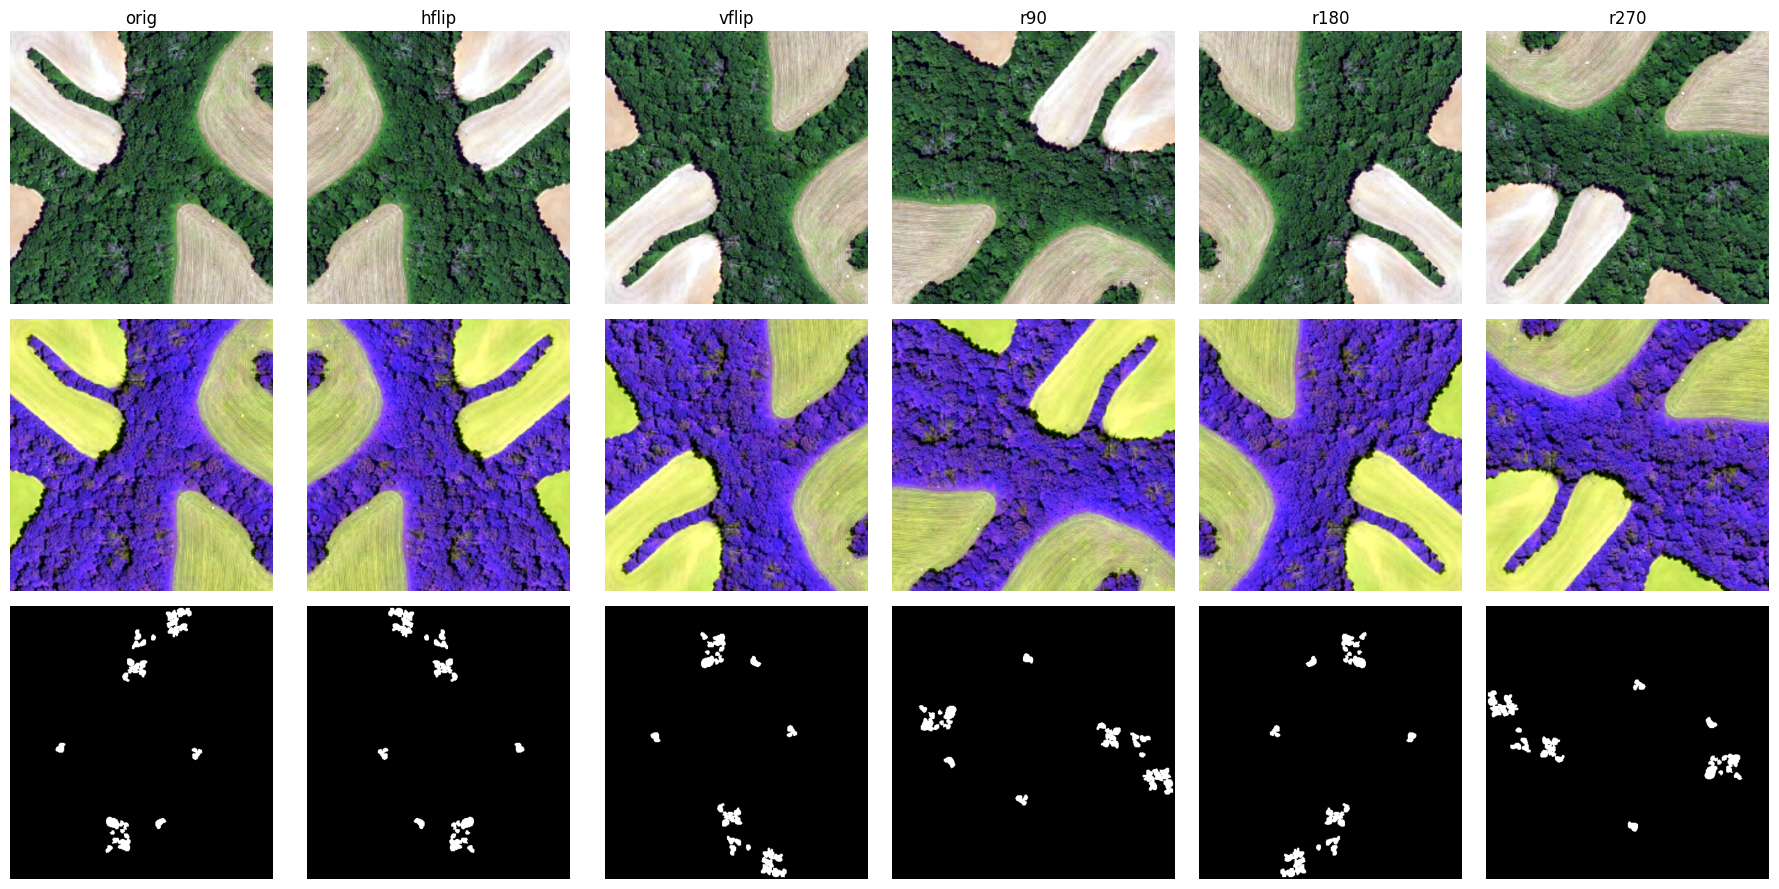

[SAVE] USA_segmentation_vis\ar041_2021_21_14_0_aug_grid.png


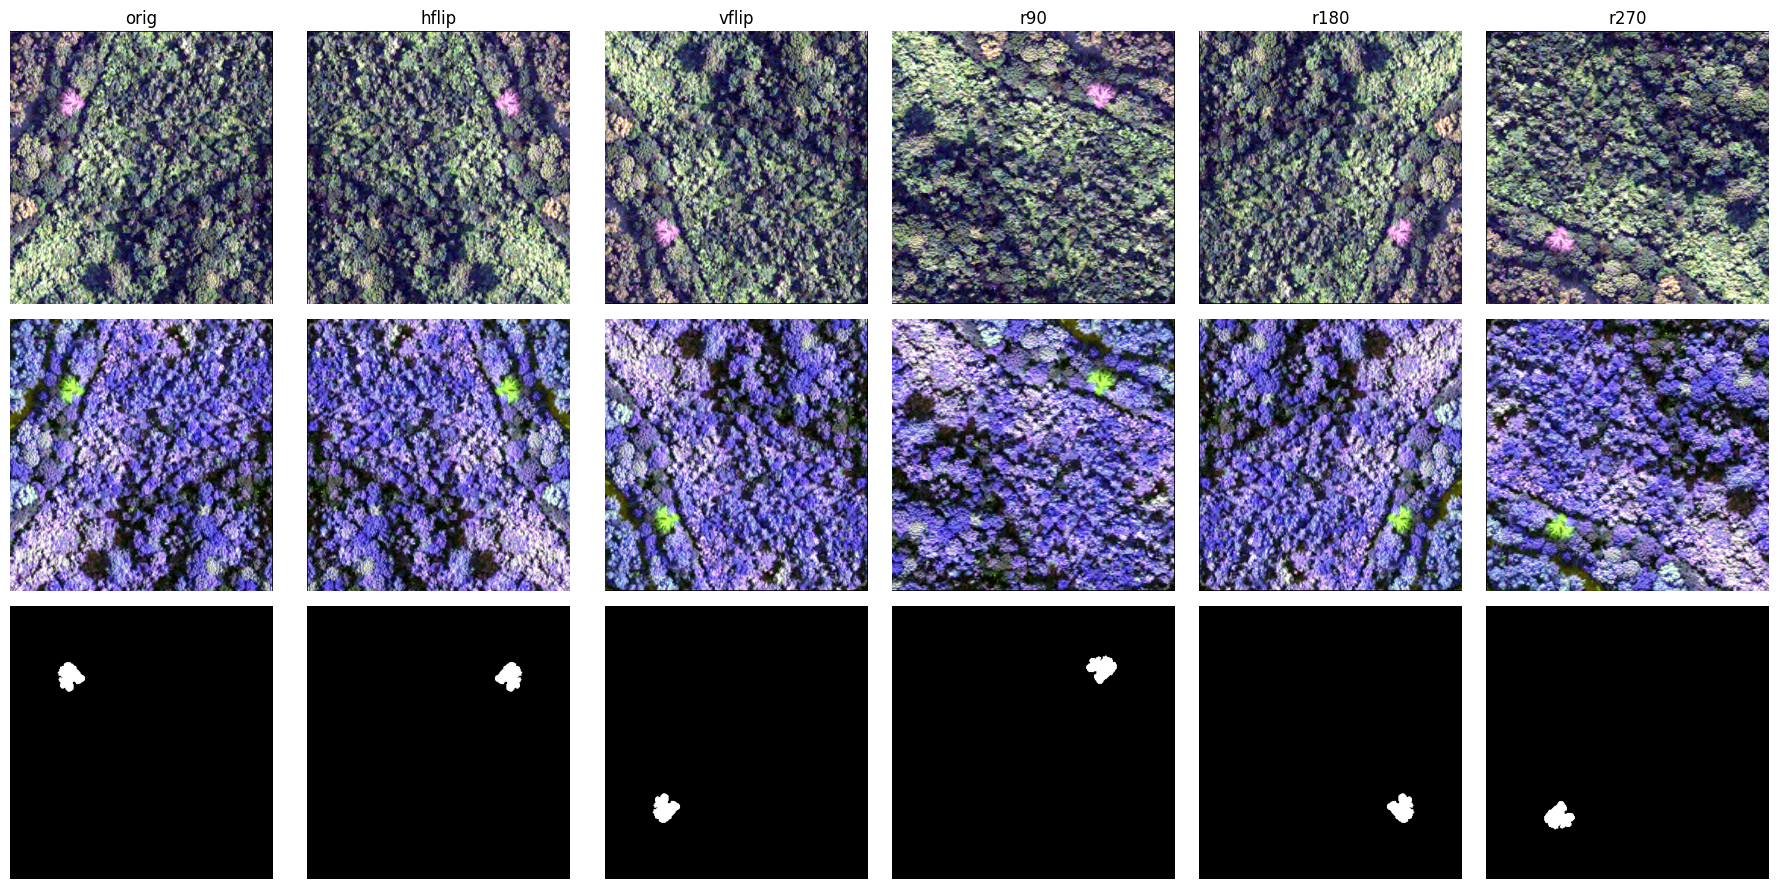

In [26]:
# === 可视化：原图与 5 种几何增强（RGB / NRG / mask）===
import matplotlib.pyplot as plt

VIS_DIR = Path("./USA_segmentation_vis")
VIS_DIR.mkdir(parents=True, exist_ok=True)

AUGS_TO_SHOW = ["orig", "hflip", "vflip", "r90", "r180", "r270"]

def read_triplet_from_key(key):
    rgb_name, nir_name, msk_name = key_to_names(key)
    rgb_path = SRC_RGB / f"{rgb_name}{IMAGE_EXT}"
    nir_path = SRC_NIR / f"{nir_name}{IMAGE_EXT}"
    msk_path = SRC_MSK / f"{msk_name}{MASK_EXT}"
    rgb = cv2.cvtColor(cv2.imread(str(rgb_path), cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
    nir = cv2.imread(str(nir_path), cv2.IMREAD_UNCHANGED)
    msk = cv2.imread(str(msk_path), cv2.IMREAD_GRAYSCALE)
    if rgb is None or nir is None or msk is None:
        raise FileNotFoundError(f"读图失败: {key}")
    msk = (msk > 127).astype(np.uint8) * 255
    return rgb, nir, msk

def make_aug(rgb, nir, msk, aug):
    if aug == "orig":
        return rgb, nir, msk
    return do_aug_triplet(rgb, nir, msk, aug)

def show_and_save_grid(key, max_w=18, max_h=9):
    rgb, nir, msk = read_triplet_from_key(key)
    rows, cols = 3, len(AUGS_TO_SHOW)
    fig, axes = plt.subplots(rows, cols, figsize=(max_w, max_h))
    # 第一行：RGB；第二行：NRG（灰度显示）；第三行：mask（灰度）
    for j, aug in enumerate(AUGS_TO_SHOW):
        r2, n2, m2 = make_aug(rgb, nir, msk, aug)
        # RGB
        axes[0, j].imshow(r2)
        axes[0, j].set_title(aug); axes[0, j].axis("off")
        # NRG
        axes[1, j].imshow(n2, cmap="gray")
        axes[1, j].axis("off")
        # mask
        axes[2, j].imshow(m2, cmap="gray")
        axes[2, j].axis("off")
    plt.tight_layout()
    out_path = VIS_DIR / f"{key}_aug_grid.png"
    plt.savefig(out_path, dpi=150, bbox_inches="tight")
    print(f"[SAVE] {out_path}")
    plt.show()

# ——示例：随机挑 3 个训练样本可视化——
train_keys = [x.strip() for x in (SPLIT_DIR/"train.txt").read_text(encoding="utf-8").splitlines() if x.strip()]
random.shuffle(train_keys)
for k in train_keys[:3]:
    show_and_save_grid(k)


In [27]:
from pathlib import Path

augs = ["hflip","vflip","r90","r180","r270"]
p = Path("./USA_segmentation/splits/train.txt")
keys = [x.strip() for x in p.read_text(encoding="utf-8").splitlines() if x.strip()]

out = []
for k in keys:
    out.append(k)  # 原样本
    out += [f"{k}_aug-{a}" for a in augs]  # 增强样本

Path("./USA_segmentation/splits/train_plus_aug.txt").write_text("\n".join(out), encoding="utf-8")
print("train_plus_aug.txt 写好，共:", len(out))


train_plus_aug.txt 写好，共: 1860


In [29]:
# === 2. 通道融合与预处理 ===
import numpy as np
import cv2
from pathlib import Path
from tqdm import tqdm

class ImagePreprocessor:
    def __init__(self, root_dir="./USA_segmentation"):
        self.root_dir = Path(root_dir)
        self.rgb_dir = self.root_dir / "RGB_images"
        self.nir_dir = self.root_dir / "NRG_images"
        self.mask_dir = self.root_dir / "masks"
        
    def compute_ndvi(self, red, nir):
        """计算NDVI: (NIR-RED)/(NIR+RED)"""
        red = red.astype(np.float32)
        nir = nir.astype(np.float32)
        numerator = nir - red
        denominator = nir + red
        ndvi = np.zeros_like(red)
        valid = denominator != 0
        ndvi[valid] = numerator[valid] / denominator[valid]
        return ndvi
    
    def normalize_image(self, img):
        """逐通道标准化"""
        mean = np.mean(img, axis=(0,1))
        std = np.std(img, axis=(0,1))
        return (img - mean) / (std + 1e-8)
    
    def process_single(self, key):
        """处理单个样本"""
        # 读取图像
        rgb_name, nir_name, mask_name = key_to_names(key)
        rgb = cv2.imread(str(self.rgb_dir/f"{rgb_name}.png"), cv2.IMREAD_COLOR)
        nir = cv2.imread(str(self.nir_dir/f"{nir_name}.png"), cv2.IMREAD_GRAYSCALE)
        
        if rgb is None or nir is None:
            raise FileNotFoundError(f"无法读取图像: {key}")
            
        # BGR -> RGB
        rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
        
        # 计算NDVI (使用R通道和NIR)
        ndvi = self.compute_ndvi(rgb[:,:,0], nir)
        
        # 融合通道: RGB + NIR + NDVI
        merged = np.dstack([rgb, nir, ndvi])
        
        # 标准化
        normalized = self.normalize_image(merged)
        
        return normalized
    
    def process_batch(self, keys, output_dir="./processed_data"):
        """批量处理并保存"""
        output_dir = Path(output_dir)
        output_dir.mkdir(parents=True, exist_ok=True)
        
        for key in tqdm(keys, desc="处理图像"):
            try:
                processed = self.process_single(key)
                # 保存为npz格式
                out_path = output_dir / f"{key}_processed.npz"
                np.savez_compressed(str(out_path), 
                                  data=processed)
            except Exception as e:
                print(f"处理失败 {key}: {str(e)}")

# 使用示例
if __name__ == "__main__":
    # 读取训练集列表
    train_file = Path("./USA_segmentation/splits/train.txt")
    train_keys = [x.strip() for x in train_file.read_text(encoding="utf-8").splitlines() if x.strip()]
    
    # 初始化处理器
    processor = ImagePreprocessor()
    
    # 处理训练集
    processor.process_batch(train_keys, "./processed_train")

处理图像: 100%|██████████| 310/310 [01:13<00:00,  4.22it/s]


In [30]:
# === 2. 通道融合与预处理 ===
# ...保持ImagePreprocessor类的代码不变...

# 使用示例
if __name__ == "__main__":
    # 读取所有数据集列表
    SPLITS = ["train.txt", "val.txt", "test.txt"]
    processor = ImagePreprocessor()
    
    for split_file in SPLITS:
        # 读取对应集合的keys
        file_path = Path("./USA_segmentation/splits") / split_file
        if not file_path.exists():
            print(f"[WARN] 找不到文件: {split_file}")
            continue
            
        keys = [x.strip() for x in file_path.read_text(encoding="utf-8").splitlines() if x.strip()]
        print(f"\n处理{split_file}中的样本，共{len(keys)}个...")
        
        # 确定输出目录（processed_train/processed_val/processed_test）
        output_dir = f"./processed_{split_file.split('.')[0]}"
        
        # 处理当前数据集
        processor.process_batch(keys, output_dir)
        
    print("\n所有数据集处理完成!")


处理train.txt中的样本，共310个...


处理图像: 100%|██████████| 310/310 [01:13<00:00,  4.24it/s]



处理val.txt中的样本，共65个...


处理图像: 100%|██████████| 65/65 [00:15<00:00,  4.21it/s]



处理test.txt中的样本，共69个...


处理图像: 100%|██████████| 69/69 [00:16<00:00,  4.18it/s]


所有数据集处理完成!


In [31]:
from pathlib import Path

# 检查处理后的文件数
for split in ['train', 'val', 'test']:
    dir_ = Path(f"./processed_{split}")
    if dir_.exists():
        n_files = len(list(dir_.glob("*.npz")))
        print(f"{split}: {n_files} files")

train: 310 files
val: 65 files
test: 69 files


In [32]:
# 随机检查几个处理后的样本
import numpy as np
import random

proc_files = list(Path("./processed_train").glob("*.npz"))
for f in random.sample(proc_files, 3):
    data = np.load(f)['data']
    print(f"文件: {f.name}")
    print(f"形状: {data.shape}")
    print(f"通道数: {data.shape[-1]}")
    print("-" * 30)

文件: mo119_2022_09_12_0_processed.npz
形状: (396, 430, 5)
通道数: 5
------------------------------
文件: mo119_2022_07_15_0_processed.npz
形状: (330, 365, 5)
通道数: 5
------------------------------
文件: mo103_2020_06_01_0_processed.npz
形状: (385, 400, 5)
通道数: 5
------------------------------


In [33]:
# 统计所有处理后样本的尺寸分布
sizes = []
for npz_file in Path("./processed_train").glob("*.npz"):
    data = np.load(npz_file)['data']
    sizes.append(data.shape[:2])
    
sizes = np.array(sizes)
print("图像尺寸统计:")
print(f"高度范围: {sizes[:,0].min()} - {sizes[:,0].max()}")
print(f"宽度范围: {sizes[:,1].min()} - {sizes[:,1].max()}")

图像尺寸统计:
高度范围: 294 - 636
宽度范围: 317 - 652



=== 文件: ar081_2021_07_04_0_processed.npz ===
R   : [-1.594,  2.691], mean=-0.000, std= 1.000
G   : [-1.481,  2.495], mean=-0.000, std= 1.000
B   : [-1.815,  2.833], mean=-0.000, std= 1.000
NIR : [-1.684,  2.543], mean= 0.000, std= 1.000
NDVI: [-2.683,  6.644], mean=-0.000, std= 1.000


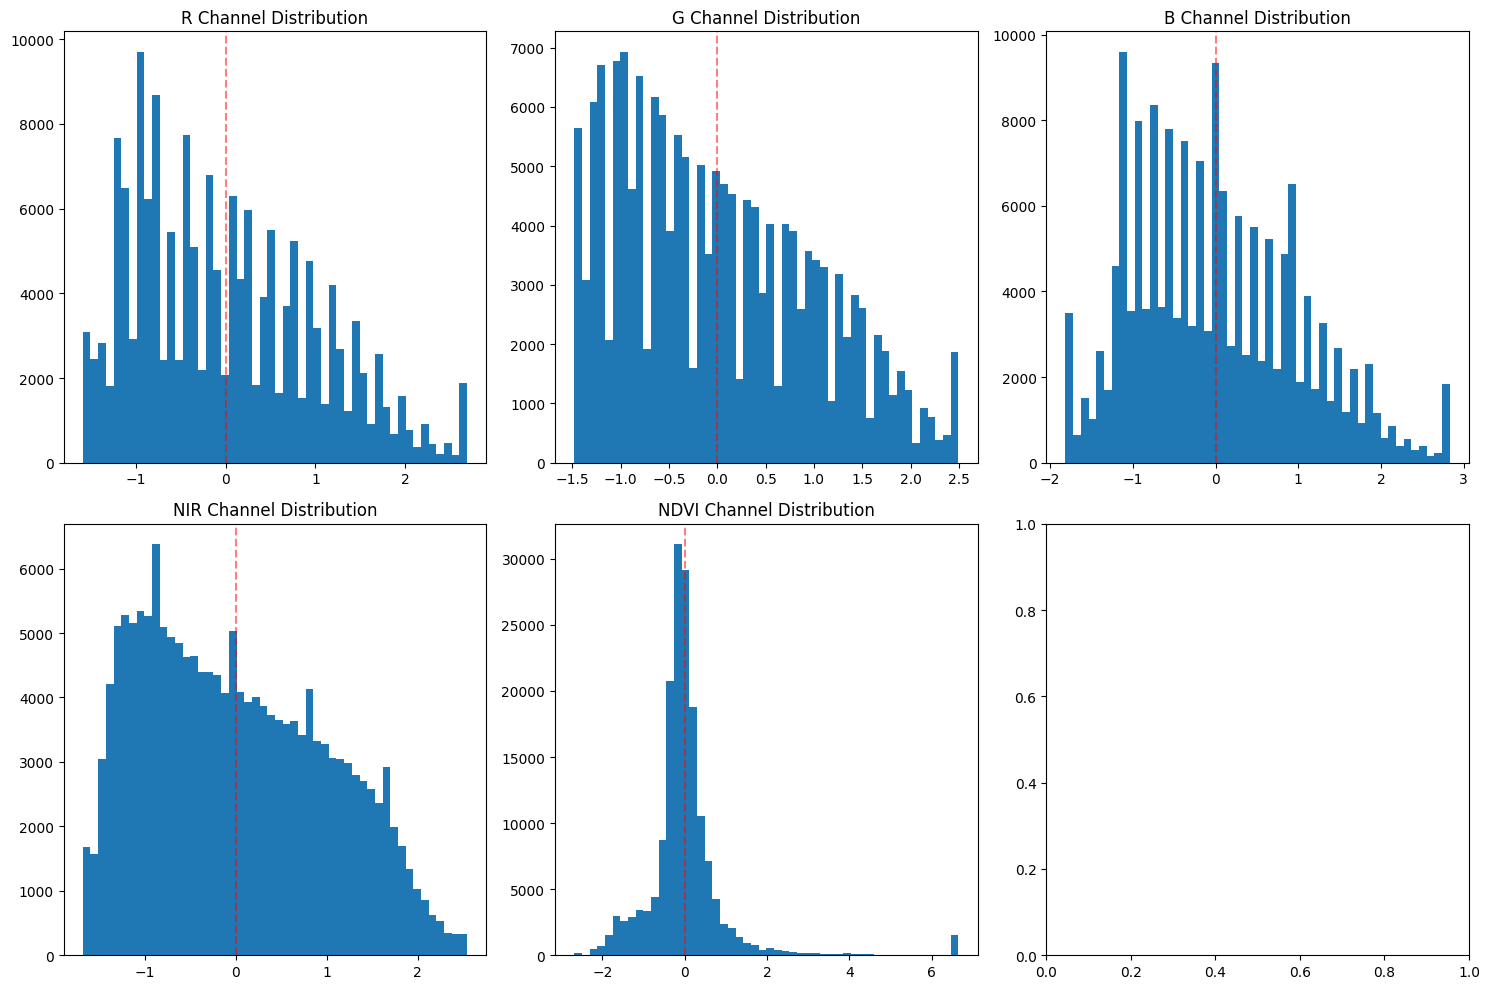


=== 文件: nm039_2022_39_40_0_processed.npz ===
R   : [-1.957,  1.981], mean= 0.000, std= 1.000
G   : [-2.074,  1.922], mean=-0.000, std= 1.000
B   : [-2.026,  2.194], mean= 0.000, std= 1.000
NIR : [-2.125,  2.070], mean= 0.000, std= 1.000
NDVI: [-8.627,  8.211], mean= 0.000, std= 1.000


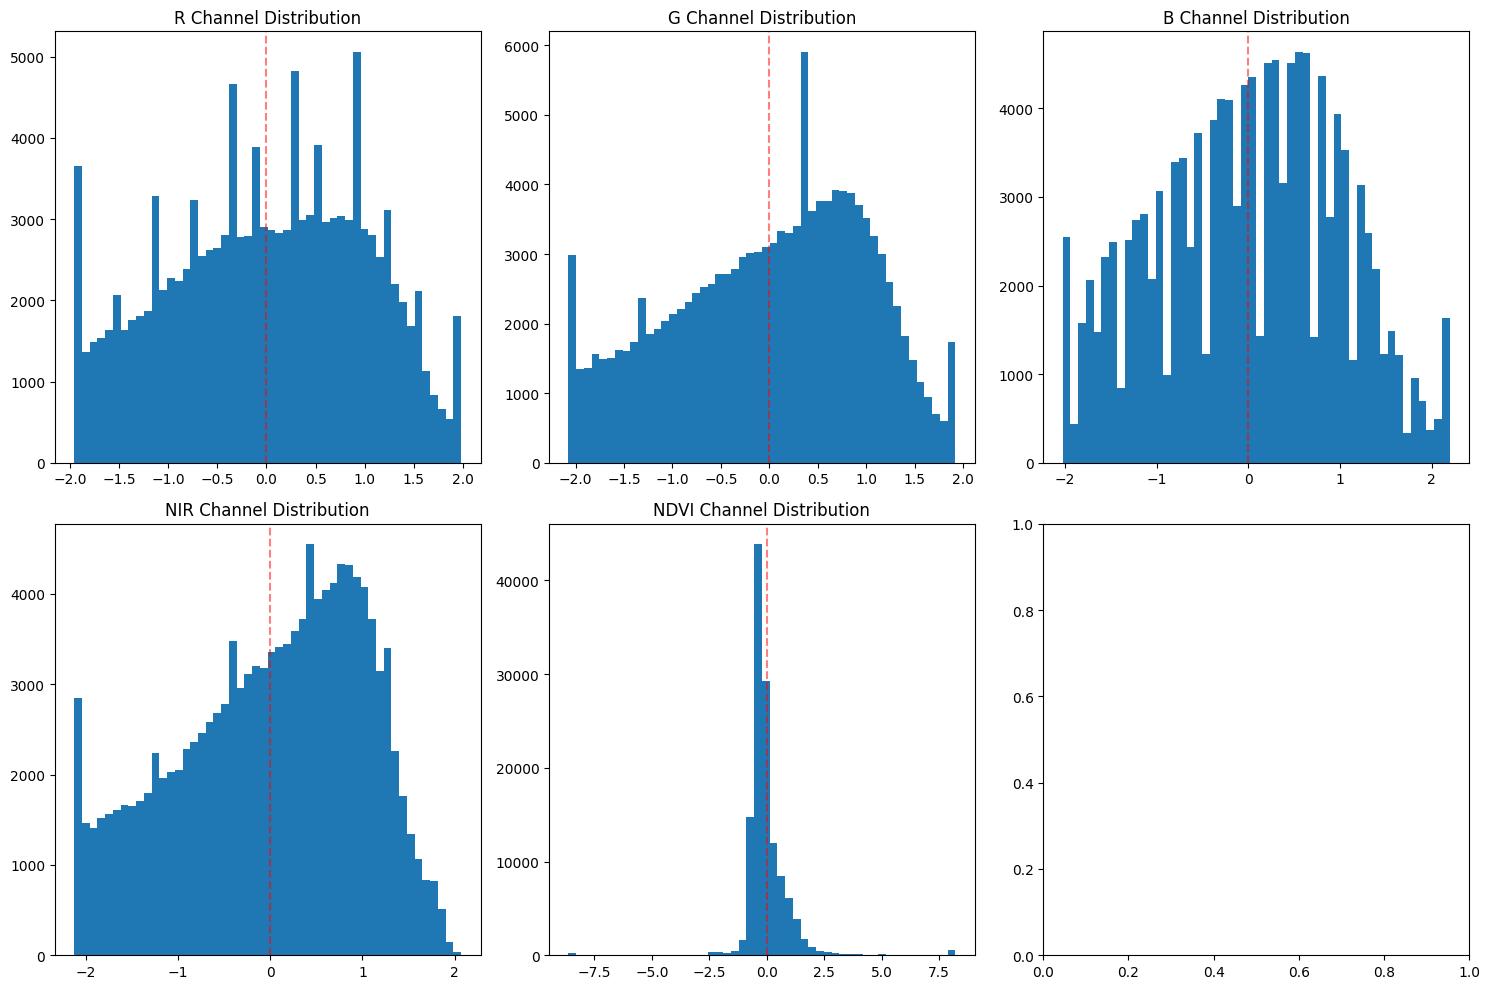


=== 文件: wa031_2021_13_03_0_processed.npz ===
R   : [-1.074,  3.295], mean=-0.000, std= 1.000
G   : [-1.287,  2.439], mean= 0.000, std= 1.000
B   : [-1.226,  3.615], mean= 0.000, std= 1.000
NIR : [-1.557,  2.814], mean=-0.000, std= 1.000
NDVI: [-6.062,  3.403], mean=-0.000, std= 1.000


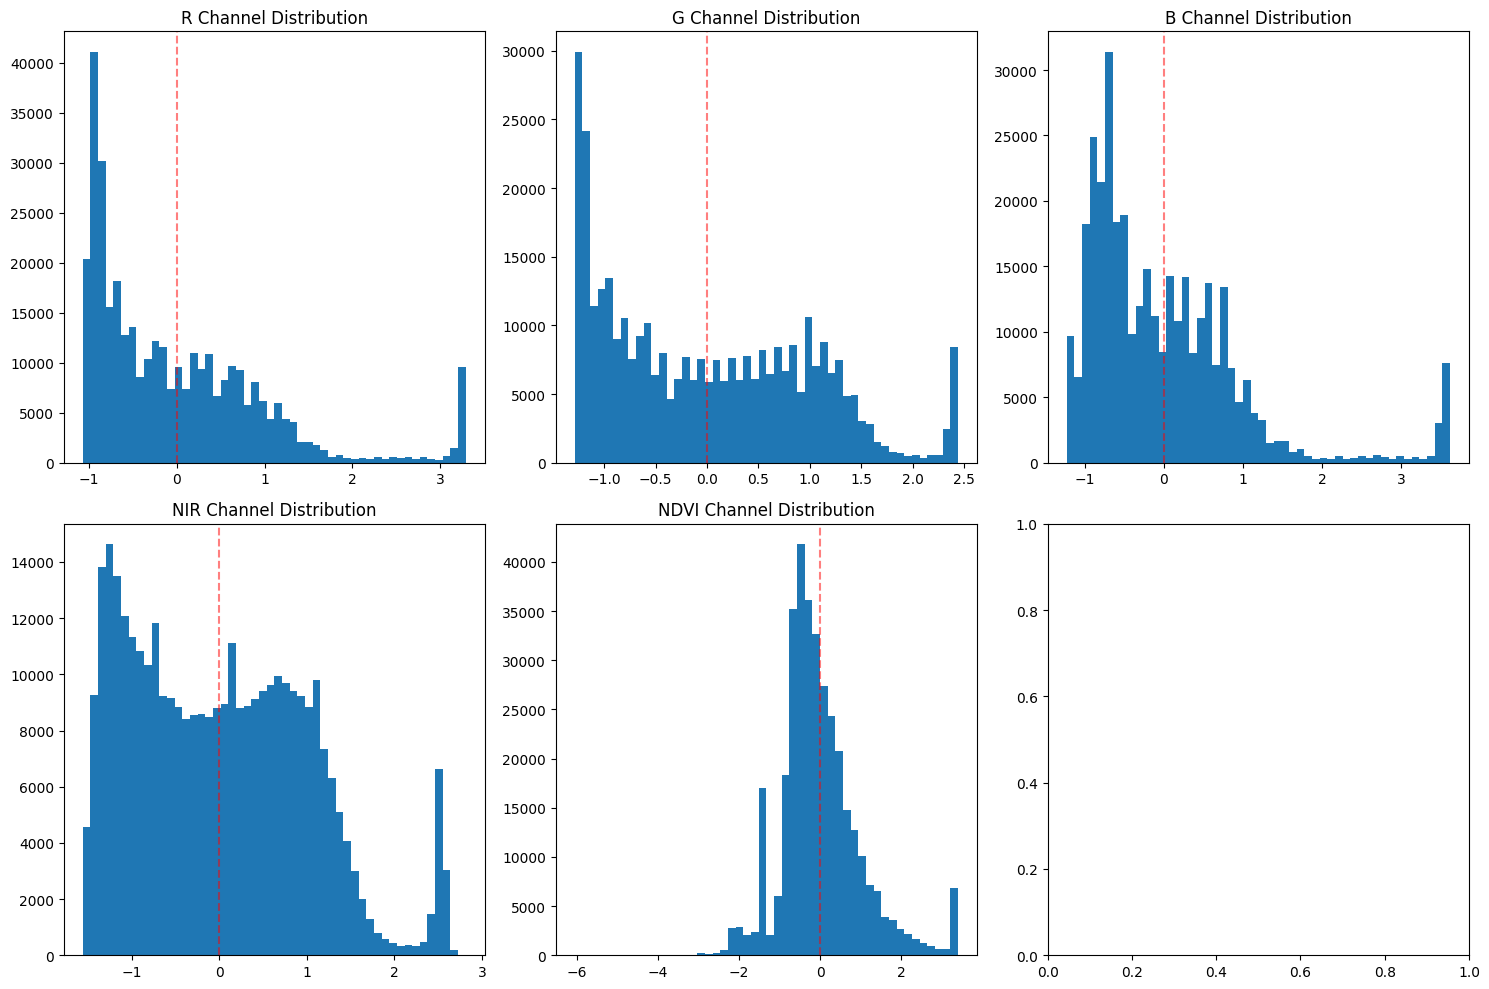

In [37]:
# 检查标准化后的数值范围并可视化
import numpy as np
import random
import matplotlib.pyplot as plt

def analyze_channels(npz_file):
    """分析所有通道的值分布并可视化"""
    data = np.load(npz_file)['data']
    
    # 创建子图
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()
    
    channel_names = ['R', 'G', 'B', 'NIR', 'NDVI']
    
    print(f"\n=== 文件: {npz_file.name} ===")
    for i in range(5):
        channel = data[..., i]
        print(f"{channel_names[i]:4s}: [{channel.min():6.3f}, {channel.max():6.3f}], "
              f"mean={channel.mean():6.3f}, std={channel.std():6.3f}")
        
        # 绘制直方图
        axes[i].hist(channel.ravel(), bins=50)
        axes[i].set_title(f"{channel_names[i]} Channel Distribution")
        axes[i].axvline(x=0, color='r', linestyle='--', alpha=0.5)  # 在0处画一条竖线
    
    plt.tight_layout()
    plt.show()

# 随机选择3个样本进行分析
proc_files = list(Path("./processed_train").glob("*.npz"))
for f in random.sample(proc_files, 3):
    analyze_channels(f)

In [3]:
def resize_batch(npz_files, target_size=(512, 512)):
    """将所有图像统一调整到相同尺寸"""
    resized_data = []
    for f in tqdm(npz_files, desc="调整图像尺寸"):
        data = np.load(f)['data']
        resized = cv2.resize(data, target_size, interpolation=cv2.INTER_LINEAR)
        resized_data.append(resized)
    return np.array(resized_data)

In [40]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import cv2
from pathlib import Path

class SatelliteDataset(Dataset):
    """Satellite image segmentation dataset"""
    def __init__(self, data_dir, target_size=(512, 512)):
        """
        Args:
            data_dir: Directory containing .npz files
            target_size: (width, height) for resizing images
        """
        self.data_dir = Path(data_dir)
        self.data_files = sorted(list(self.data_dir.glob("*.npz")))
        self.target_size = target_size
        
        # Validate directory and data
        if not self.data_dir.exists():
            raise RuntimeError(f"Data directory not found: {data_dir}")
        if len(self.data_files) == 0:
            raise RuntimeError(f"No .npz files found in {data_dir}")
        
        # Validate first sample
        try:
            self[0]
        except Exception as e:
            raise RuntimeError(f"Failed to load first sample: {str(e)}")
    
    def __len__(self):
        return len(self.data_files)
    
    def __getitem__(self, idx):
        try:
            # Load preprocessed data
            data = np.load(self.data_files[idx])['data']
            
            # Resize to target size
            if self.target_size:
                data = cv2.resize(data, self.target_size, 
                                interpolation=cv2.INTER_LINEAR)
            
            # Convert to PyTorch tensor
            data = torch.from_numpy(data).float()
            data = data.permute(2, 0, 1)  # (H,W,C) -> (C,H,W)
            
            return data
            
        except Exception as e:
            print(f"Error loading sample {self.data_files[idx]}: {str(e)}")
            raise

# Test the modified dataloader
if __name__ == "__main__":
    # Create dataset with fixed size
    train_dataset = SatelliteDataset(
        data_dir="./processed_train",
        target_size=(512, 512)  # Set target size
    )
    print(f"Dataset size: {len(train_dataset)}")
    
    # Check single sample
    sample = train_dataset[0]
    print(f"Sample shape: {sample.shape}")
    print(f"Value range: [{sample.min().item():.3f}, {sample.max().item():.3f}]")
    
    # Create DataLoader
    train_loader = DataLoader(
        train_dataset,
        batch_size=4,
        shuffle=True,
        num_workers=0,
        pin_memory=False
    )
    
    # Check one batch
    try:
        for batch in train_loader:
            print(f"Batch shape: {batch.shape}")
            print(f"Value range: [{batch.min().item():.3f}, {batch.max().item():.3f}]")
            break
    except Exception as e:
        print(f"Error loading batch: {str(e)}")

Dataset size: 310
Sample shape: torch.Size([5, 512, 512])
Value range: [-3.343, 6.067]
Batch shape: torch.Size([4, 5, 512, 512])
Value range: [-7.948, 6.382]


In [42]:
class SatelliteDataset(Dataset):
    def __init__(self, data_dir, mask_dir, target_size=(512, 512)):
        self.data_dir = Path(data_dir)
        self.mask_dir = Path(mask_dir)
        self.target_size = target_size

        if not self.data_dir.exists():
            raise RuntimeError(f"数据目录不存在: {data_dir}")
        if not self.mask_dir.exists():
            raise RuntimeError(f"掩码目录不存在: {mask_dir}")

        self.data_files = sorted(list(self.data_dir.glob("*.npz")))
        if len(self.data_files) == 0:
            raise RuntimeError(f"在 {data_dir} 中未找到 .npz 文件")

        # 映射 npz -> mask（兼容 *_processed.npz 和 *_aug-xxx）
        self.valid_pairs = []
        for data_file in self.data_files:
            base = data_file.stem  # e.g., wa041_2019_10_33_0_processed
            base = base.replace("_processed", "")
            # 去掉可能的 _aug- 后缀（如果你以后要启用离线增强）
            base = base.split("_aug-")[0]

            # 期望 key: state_year_month_day_index
            parts = base.split("_")
            if len(parts) == 5:
                state, year, month, day, index = parts
                mask_name = f"mask_{state}_{year}_n_{month}_{day}_{index}.png"
                mask_path = self.mask_dir / mask_name
                if mask_path.exists():
                    self.valid_pairs.append((data_file, mask_path))

        if len(self.valid_pairs) == 0:
            raise RuntimeError("没有找到有效的数据-掩码对！请检查文件命名模式。")

        print(f"[INFO] 有效样本对: {len(self.valid_pairs)}")

    def __len__(self):
        return len(self.valid_pairs)

    def __getitem__(self, idx):
        data_file, mask_file = self.valid_pairs[idx]
        data = np.load(data_file)['data']            # (H,W,5) 已经标准化
        mask = cv2.imread(str(mask_file), 0)         # (H,W)

        if self.target_size:
            data = cv2.resize(data, self.target_size, interpolation=cv2.INTER_LINEAR)
            mask = cv2.resize(mask, self.target_size, interpolation=cv2.INTER_NEAREST)

        mask = (mask > 127).astype(np.float32)       # 0/1
        data = torch.from_numpy(data).float().permute(2,0,1)  # -> (C,H,W)
        mask = torch.from_numpy(mask).float().unsqueeze(0)     # -> (1,H,W)
        return data, mask


In [7]:
def validate_dataset(data_dir, mask_dir):
    """Validate dataset integrity"""
    dataset = SatelliteDataset(data_dir, mask_dir)
    print(f"Found {len(dataset)} samples")
    
    # Test loading
    data, mask = dataset[0]
    print(f"Data shape: {data.shape}")
    print(f"Mask shape: {mask.shape}")
    print(f"Data range: [{data.min():.3f}, {data.max():.3f}]")
    print(f"Mask values: {torch.unique(mask)}")
    
    return dataset

In [8]:
# Training configuration
CONFIG = {
    'batch_size': 8,
    'num_workers': 2,
    'learning_rate': 1e-4,
    'epochs': 100,
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu')
}

In [9]:
# Training configuration with basic validation
CONFIG = {
    'batch_size': 8,
    'num_workers': 2,
    'learning_rate': 1e-4,
    'epochs': 100,
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu')
}

# Print training configuration and environment info
print("=== Training Configuration ===")
print(f"Batch size: {CONFIG['batch_size']}")
print(f"Number of workers: {CONFIG['num_workers']}")
print(f"Learning rate: {CONFIG['learning_rate']}")
print(f"Number of epochs: {CONFIG['epochs']}")
print(f"Device: {CONFIG['device']}")

# Check CUDA availability
if torch.cuda.is_available():
    print("\n=== CUDA Information ===")
    print(f"CUDA available: Yes")
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU device: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
else:
    print("\nWarning: CUDA not available, using CPU for training")

# Validate configuration
assert CONFIG['batch_size'] > 0, "Batch size must be positive"
assert CONFIG['num_workers'] >= 0, "Number of workers must be non-negative"
assert CONFIG['learning_rate'] > 0, "Learning rate must be positive"
assert CONFIG['epochs'] > 0, "Number of epochs must be positive"
print("\n[SUCCESS] Configuration validated")

=== Training Configuration ===
Batch size: 8
Number of workers: 2
Learning rate: 0.0001
Number of epochs: 100
Device: cuda

=== CUDA Information ===
CUDA available: Yes
CUDA version: 11.8
GPU device: NVIDIA GeForce RTX 4060 Laptop GPU
GPU memory: 8.0 GB

[SUCCESS] Configuration validated


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvBlock(nn.Module):
    """双卷积块"""
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    """改进的U-Net模型，输入为5通道（RGB + NIR + NDVI）"""
    def __init__(self, n_channels=5, n_classes=1):
        super().__init__()
        
        # 编码器
        self.inc = ConvBlock(n_channels, 64)
        self.down1 = nn.Sequential(
            nn.MaxPool2d(2),
            ConvBlock(64, 128)
        )
        self.down2 = nn.Sequential(
            nn.MaxPool2d(2),
            ConvBlock(128, 256)
        )
        self.down3 = nn.Sequential(
            nn.MaxPool2d(2),
            ConvBlock(256, 512)
        )

        # 解码器
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv3 = ConvBlock(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv2 = ConvBlock(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv1 = ConvBlock(128, 64)
        
        # 输出层
        self.outc = nn.Conv2d(64, n_classes, 1)
        
    def forward(self, x):
        # 编码路径
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        
        # 解码路径（带跳跃连接）
        x = self.up3(x4)
        x = self.conv3(torch.cat([x, x3], dim=1))
        x = self.up2(x)
        x = self.conv2(torch.cat([x, x2], dim=1))
        x = self.up1(x)
        x = self.conv1(torch.cat([x, x1], dim=1))
        
        # 输出
        logits = self.outc(x)
        return torch.sigmoid(logits)

# 测试模型
if __name__ == "__main__":
    # 创建模型实例
    model = UNet().to(CONFIG['device'])
    print(model)
    
    # 测试前向传播
    batch_size = 2
    x = torch.randn(batch_size, 5, 512, 512).to(CONFIG['device'])
    with torch.no_grad():
        y = model(x)
    print(f"\n输入形状: {x.shape}")
    print(f"输出形状: {y.shape}")
    print(f"输出范围: [{y.min().item():.3f}, {y.max().item():.3f}]")
    
    # 计算模型参数量
    total_params = sum(p.numel() for p in model.parameters())
    print(f"\n模型总参数量: {total_params:,}")

UNet(
  (inc): ConvBlock(
    (conv): Sequential(
      (0): Conv2d(5, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): ConvBlock(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5)

In [36]:
# 测试数据集大小
train_dataset = SatelliteDataset(
    data_dir="./processed_train",
    mask_dir="./USA_segmentation/masks",
    target_size=(512, 512)
)
print(f"训练集大小: {len(train_dataset)}")

# 测试数据加载
train_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=0
)

# 检查一个批次
for batch_data, batch_masks in train_loader:
    print(f"批次形状: {batch_data.shape}")
    print(f"掩码形状: {batch_masks.shape}")
    break


=== 初始化数据集 ===
数据目录: processed_train
掩码目录: USA_segmentation\masks
[INFO] 找到 310 个数据文件
[INFO] 找到 310 个有效样本对
训练集大小: 310
批次形状: torch.Size([4, 5, 512, 512])
掩码形状: torch.Size([4, 512, 512])


In [47]:
class UNet(nn.Module):
    def __init__(self, n_channels=5, n_classes=1):
        super().__init__()
        self.inc = ConvBlock(n_channels, 64)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), ConvBlock(64, 128))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), ConvBlock(128, 256))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), ConvBlock(256, 512))
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2); self.conv3 = ConvBlock(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2); self.conv2 = ConvBlock(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2);  self.conv1 = ConvBlock(128, 64)
        self.outc = nn.Conv2d(64, n_classes, 1)

    def forward(self, x):
        x1 = self.inc(x); x2 = self.down1(x1); x3 = self.down2(x2); x4 = self.down3(x3)
        x = self.up3(x4); x = self.conv3(torch.cat([x, x3], dim=1))
        x = self.up2(x); x = self.conv2(torch.cat([x, x2], dim=1))
        x = self.up1(x); x = self.conv1(torch.cat([x, x1], dim=1))
        logits = self.outc(x)              # 注意：不做 sigmoid
        return logits


In [48]:
def iou_from_logits(logits, targets, thr=0.5, eps=1e-7):
    # logits: (B,1,H,W), targets: (B,1,H,W)
    probs = torch.sigmoid(logits)
    preds = (probs > thr).float()
    inter = (preds * targets).sum(dim=(1,2,3))
    union = (preds + targets).clamp(max=1).sum(dim=(1,2,3))
    iou = (inter + eps) / (union + eps)
    return iou.mean().item()


In [50]:
import torch.optim as optim
from torch.nn import BCEWithLogitsLoss
from tqdm import tqdm

def train_model(model, train_loader, val_loader, config):
    optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
    criterion = BCEWithLogitsLoss()

    best_val_iou = -1.0
    best_state = None

    for epoch in range(config['epochs']):
        model.train()
        train_loss = 0.0
        for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['epochs']} - train"):
            x, y = x.to(config['device']), y.to(config['device'])
            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * x.size(0)
        train_loss /= len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        val_iou  = 0.0
        n = 0
        with torch.no_grad():
            for x, y in tqdm(val_loader, desc=f"Epoch {epoch+1}/{config['epochs']} - val"):
                x, y = x.to(config['device']), y.to(config['device'])
                logits = model(x)
                loss = criterion(logits, y)
                val_loss += loss.item() * x.size(0)
                val_iou  += iou_from_logits(logits, y) * x.size(0)
                n += x.size(0)
        val_loss /= max(1,n)
        val_iou  /= max(1,n)

        print(f"Epoch {epoch+1}: train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | val_IoU={val_iou:.4f}")

        if val_iou > best_val_iou:
            best_val_iou = val_iou
            best_state = model.state_dict()
            torch.save(best_state, "best_model.pth")
            print(f"  -> 保存最佳模型：val_IoU={best_val_iou:.4f}")

    return best_state, {'val_iou': best_val_iou}


In [52]:
from pathlib import Path
import torch
from torch.utils.data import DataLoader

# 先检查必要对象是否已定义
missing = [name for name in ["SatelliteDataset", "UNet", "CONFIG"] if name not in globals()]
if missing:
    raise RuntimeError(f"缺少定义：{missing}。请先执行包含 SatelliteDataset/UNet/CONFIG 的单元格。")

print("== Sanity start ==")

# 1) 路径与文件数
for split in ["train","val"]:
    p = Path(f"./processed_{split}")
    n = len(list(p.glob("*.npz"))) if p.exists() else 0
    print(f"{split:5s} exists={p.exists()}  npz_count={n}")

# 2) 构建数据集
train_dataset = SatelliteDataset("./processed_train", "./USA_segmentation/masks", target_size=(512,512))
val_dataset   = SatelliteDataset("./processed_val",   "./USA_segmentation/masks", target_size=(512,512))
print("dataset sizes ->", len(train_dataset), len(val_dataset))

# 3) 看一个样本
x0, y0 = train_dataset[0]
print(f"sample shapes -> x:{tuple(x0.shape)} y:{tuple(y0.shape)} "
      f"value range: [{float(x0.min()):.3f}, {float(x0.max()):.3f}]")

# 4) DataLoader（num_workers=0 防止卡住）
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0, pin_memory=False)
val_loader   = DataLoader(val_dataset,   batch_size=2, shuffle=False, num_workers=0, pin_memory=False)

# 5) 模型与一次前向
model = UNet().to(CONFIG['device'])
xb, yb = next(iter(train_loader))
xb = xb.to(CONFIG['device']); yb = yb.to(CONFIG['device'])
with torch.no_grad():
    logits = model(xb)
print("forward ok ->", tuple(logits.shape))

# 6) 跑 1 个迷你 epoch（不使用 tqdm，强制打印）
from torch.nn import BCEWithLogitsLoss
import torch.optim as optim

def iou_from_logits(logits, targets, thr=0.5, eps=1e-7):
    probs = torch.sigmoid(logits)
    preds = (probs > thr).float()
    inter = (preds * targets).sum(dim=(1,2,3))
    union = (preds + targets).clamp(max=1).sum(dim=(1,2,3))
    return ((inter+eps)/(union+eps)).mean().item()

criterion = BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'])

print("== Train epoch 1/1 ==")
model.train(); run_loss=0.0; seen=0
for x, y in train_loader:
    x, y = x.to(CONFIG['device']), y.to(CONFIG['device'])
    optimizer.zero_grad()
    logits = model(x)
    loss = criterion(logits, y)
    loss.backward(); optimizer.step()
    run_loss += loss.item() * x.size(0); seen += x.size(0)
print("train_loss =", run_loss/max(1,seen))

model.eval(); vl=0.0; viou=0.0; vs=0
with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(CONFIG['device']), y.to(CONFIG['device'])
        logits = model(x)
        vl   += criterion(logits, y).item() * x.size(0)
        viou += iou_from_logits(logits, y) * x.size(0)
        vs   += x.size(0)
print("val_loss =", vl/max(1,vs), "val_IoU =", viou/max(1,vs))



== Sanity start ==
train exists=True  npz_count=310
val   exists=True  npz_count=65
[INFO] 有效样本对: 310
[INFO] 有效样本对: 65
dataset sizes -> 310 65
sample shapes -> x:(5, 512, 512) y:(1, 512, 512) value range: [-3.343, 6.067]
forward ok -> (2, 1, 512, 512)
== Train epoch 1/1 ==
train_loss = 0.31340566354413185
val_loss = 0.2272832425741049 val_IoU = 0.02176995897220471


In [53]:
import inspect, torch

# 打印 forward 源码
try:
    print(inspect.getsource(UNet.forward))
except Exception as e:
    print("无法读取 UNet.forward 源码：", e)

# 运行一次看看输出范围（判断是不是 0~1）
_model = UNet().to(CONFIG['device'])
x = torch.randn(2, 5, 512, 512, device=CONFIG['device'])
with torch.no_grad():
    out = _model(x)
print("output range:", float(out.min()), "→", float(out.max()))
print("Looks like", "PROBABILITIES (0~1)" if (out.min()>=0 and out.max()<=1) else "LOGITS (未过sigmoid)")


    def forward(self, x):
        x1 = self.inc(x); x2 = self.down1(x1); x3 = self.down2(x2); x4 = self.down3(x3)
        x = self.up3(x4); x = self.conv3(torch.cat([x, x3], dim=1))
        x = self.up2(x); x = self.conv2(torch.cat([x, x2], dim=1))
        x = self.up1(x); x = self.conv1(torch.cat([x, x1], dim=1))
        logits = self.outc(x)              # 注意：不做 sigmoid
        return logits

output range: -2.1622912883758545 → 1.381827712059021
Looks like LOGITS (未过sigmoid)


In [54]:
from torch.nn import BCEWithLogitsLoss
import torch

def estimate_pos_weight(loader, max_batches=10):
    pos = 0.0; tot = 0.0
    for i, (_, y) in enumerate(loader):
        pos += y.sum().item()
        tot += y.numel()
        if i+1 >= max_batches: break
    neg = max(tot - pos, 1.0)
    pw = neg / max(pos, 1.0)
    return float(max(1.0, min(pw, 1000.0)))  # 夹一下避免过大

def dice_loss_from_logits(logits, targets, eps=1e-6):
    p = torch.sigmoid(logits)
    num = 2.0 * (p * targets).sum(dim=(1,2,3)) + eps
    den = (p.pow(2) + targets.pow(2)).sum(dim=(1,2,3)) + eps
    return (1.0 - num/den).mean()


In [58]:
import torch.optim as optim

def train_model(model, train_loader, val_loader, config, alpha=0.5):
    # 估计正类权重
    pw = estimate_pos_weight(train_loader)
    print(f"[INFO] estimated pos_weight = {pw:.1f}")

    bce = BCEWithLogitsLoss(pos_weight=torch.tensor([pw], device=config['device']))
    def loss_fn(z, y):  # z = logits
        return alpha*bce(z, y) + (1-alpha)*dice_loss_from_logits(z, y)

    opt = optim.Adam(model.parameters(), lr=config['learning_rate'])

    best_val_iou, best_state = -1.0, None
    for epoch in range(config['epochs']):
        # ---- train ----
        model.train(); train_loss = 0.0
        for x, y in train_loader:
            x, y = x.to(config['device']), y.to(config['device'])
            opt.zero_grad()
            z = model(x)
            loss = loss_fn(z, y)
            loss.backward(); opt.step()
            train_loss += loss.item() * x.size(0)
        train_loss /= len(train_loader.dataset)

        # ---- validate ----
        model.eval(); val_loss=0.0; val_iou=0.0; pred_fg=0.0; n=0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(config['device']), y.to(config['device'])
                z = model(x)
                val_loss += loss_fn(z, y).item() * x.size(0)

                p = torch.sigmoid(z)
                pred = (p > 0.5).float()
                inter = (pred * y).sum(dim=(1,2,3))
                union = (pred + y).clamp(max=1).sum(dim=(1,2,3))
                val_iou += ((inter+1e-7)/(union+1e-7)).sum().item()

                pred_fg += pred.mean().item() * x.size(0)
                n += x.size(0)
        val_loss /= max(1,n); val_iou /= max(1,n); pred_fg /= max(1,n)

        print(f"Epoch {epoch+1}: train_loss={train_loss:.4f} | "
              f"val_loss={val_loss:.4f} | val_IoU={val_iou:.4f} | pred_fg%={pred_fg*100:.2f}%")

        if val_iou > best_val_iou:
            best_val_iou = val_iou
            best_state = model.state_dict()
            torch.save(best_state, "best_model.pth")
            print(f"  -> 保存最佳模型（val_IoU={best_val_iou:.4f}）")

    return best_state, {'val_iou': best_val_iou}


In [1]:
import numpy as np
def find_best_threshold(model, loader, device):
    model.eval(); ts = np.linspace(0.2, 0.8, 13)
    best_t, best_iou = 0.5, 0.0
    with torch.no_grad():
        for t in ts:
            iou_sum, n = 0.0, 0
            for x, y in loader:
                x, y = x.to(device), y.to(device)
                p = torch.sigmoid(model(x))
                pred = (p > t).float()
                inter = (pred * y).sum(dim=(1,2,3))
                union = (pred + y).clamp(max=1).sum(dim=(1,2,3))
                iou_sum += ((inter+1e-7)/(union+1e-7)).sum().item()
                n += x.size(0)
            mean_iou = iou_sum / max(1,n)
            if mean_iou > best_iou: best_iou, best_t = mean_iou, t
    print(f"[THR] best_t={best_t:.2f} val_IoU={best_iou:.4f}")
    return best_t


In [ ]:
from torch.utils.data import DataLoader

# 为了避免卡住，先把 worker 设成 0（跑通后再调回 2）
CONFIG['num_workers'] = 0

# 构建数据集与 DataLoader
train_dataset = SatelliteDataset("./processed_train", "./USA_segmentation/masks", target_size=(512,512))
val_dataset   = SatelliteDataset("./processed_val",   "./USA_segmentation/masks", target_size=(512,512))
print("sizes:", len(train_dataset), len(val_dataset), flush=True)

train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True,
                          num_workers=CONFIG['num_workers'], pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=CONFIG['batch_size'], shuffle=False,
                          num_workers=CONFIG['num_workers'], pin_memory=True)

# 实例化模型并训练（加 flush 保证即时打印）
model = UNet().to(CONFIG['device'])
print("START TRAIN", flush=True)
best_state, metrics = train_model(model, train_loader, val_loader, CONFIG, alpha=0.5)
print("DONE. best val IoU:", metrics['val_iou'], flush=True)


[INFO] 有效样本对: 310
[INFO] 有效样本对: 65
sizes: 310 65
START TRAIN
[INFO] estimated pos_weight = 61.9
Epoch 1: train_loss=0.8739 | val_loss=1.0353 | val_IoU=0.0567 | pred_fg%=35.43%
  -> 保存最佳模型（val_IoU=0.0567）
